# *Conexión al Drive*

In [ ]:
# prompt: crear conexion a drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import sys
path='/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data'
os.chdir(path)###volver la carpeta del repositorio directorio de trabajo
sys.path.append(path)### agregarla al path, para poder leer los archivos de funciones propios como paquetes

# *Librerias*

In [ ]:
###paquete para crear y trabajar con bases de datos.
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
#import a_funciones as fn
from mlxtend.preprocessing import TransactionEncoder
import re

# *Conexión a SQL*

In [ ]:
# Conectarse a la base de datos
con=sql.connect('db_movies')

In [ ]:
# Crear un cursor
cur=con.cursor()### otro tipo de conexión para ejecutar consultas en la bd sin traer ni llevar información

In [ ]:
# Obtener una lista de tablas en la base de datos
cur.execute("""SELECT name FROM sqlite_master WHERE type= 'table'; """)
tables = cur.fetchall()
print("Tablas disponibles:", tables)

Tablas disponibles: [('ratings',), ('movies',)]


### *Cargar las tablas en DataFrames*

In [ ]:
# Cargar tabla movies
cur.execute('SELECT * FROM movies')
movies_data = cur.fetchall()
movies_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
movies_df = pd.DataFrame(movies_data, columns=movies_columns)


In [ ]:
# Mostrar las primeras filas de la tabla
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Cargar tabla ratings
cur.execute('SELECT * FROM ratings')
ratings_data = cur.fetchall()
ratings_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
ratings_df = pd.DataFrame(ratings_data, columns=ratings_columns)

In [ ]:
# Mostrar las primeras filas de la tabla
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# *Cerra la conexion*

In [ ]:
# Cerrar la conexión
#cur.close()
#con.close()

# *Análisis exploratorio de los datos*

### *Verificar valores nulos en ambas tablas*

In [ ]:
# Verificar valores nulos en las tablas
print("Valores nulos en movies:")
movies_df.isnull().sum()

Valores nulos en movies:


,0
movieId,0
title,0
genres,0


In [ ]:
print("Valores nulos en ratings:")
ratings_df.isnull().sum()

Valores nulos en ratings:


,0
userId,0
movieId,0
rating,0
timestamp,0


### *Verificar el formatos en la tabla movies*

In [ ]:
# Función para separar el nombre de la película y el año
def separar_titulo_year(title):
    # Buscar el patrón de texto para el año (que está entre paréntesis)
    match = re.match(r"^(.*)\s\((\d{4})\)$", title)
    if match:
        # Si encuentra un match, devuelve el nombre y el año
        return match.group(1), int(match.group(2))
    else:
        # Si no encuentra el formato esperado, retorna el título original y un valor nulo para el año
        return title, None

# Aplicamos la función a la columna 'title'
movies_df[['movie_name', 'year']] = movies_df['title'].apply(lambda x: pd.Series(separar_titulo_year(x)))

# Convertir la columna 'year' a entero explícitamente para evitar decimales
movies_df['year'] = movies_df['year'].astype('Int64')  # Usamos 'Int64' para manejar nulos correctamente

# Verificar las primeras filas para asegurarnos de que se hizo correctamente
movies_df[['movieId', 'movie_name', 'year','genres']].head()


,movieId,movie_name,year,genres
0,1,Toy Story,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji,1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale,1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,1995,[Comedy]


In [ ]:
# Verificar el tipo de dato en la columna 'genres'
print(type(movies_df['genres'][0]))  # Verifica el tipo de la primera entrada

# Si es una lista, no necesitamos dividirla, solo procesarla
if isinstance(movies_df['genres'][0], str):
    # Si los géneros están en formato de cadena, los dividimos
    movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))

# Verificar cómo quedan los géneros después de la transformación
movies_df['genres'].head()


<class 'list'>


,genres
0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,"[Adventure, Children, Fantasy]"
2,"[Comedy, Romance]"
3,"[Comedy, Drama, Romance]"
4,[Comedy]


### *Análisis de distribuciones y actividad de usuarios*

#### *Distribución de calificaciones*

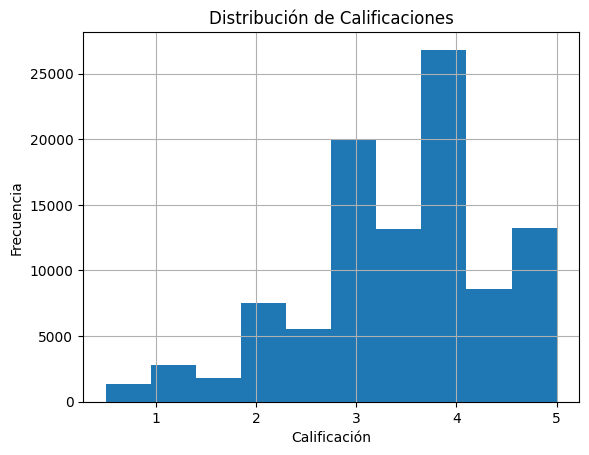

In [ ]:
# Histograma de las calificaciones
ratings_df['rating'].hist(bins=10)
plt.title("Distribución de Calificaciones")
plt.xlabel("Calificación")
plt.ylabel("Frecuencia")
plt.show()
